# PREFIRE Virtual Datacube Generation

## Overview

Create Kerchunk reference files for cloud-based PREFIRE satellite data analysis without downloading files.

**What You'll Build:**

- A 12MB Kerchunk file representing ~1GB+ of satellite data
- A virtual datacube that reads directly from cloud storage
- Visualizations from cloud data without full downloads

## Prerequisites
- virtualizarr >= 2.0.1
- NASA Earthdata account ([sign up here](https://urs.earthdata.nasa.gov/users/new))

## Virtual vs Traditional Approach

* **Traditional:** Download files (GB-TB) → Load into memory (or run out of memory) → Analyze 
* **Virtual:** Create lightweight reference files (MB) → Access on-demand (without downloading) → Analyze at scale

---

## 1. Setup

Configure authentication and initialize essential libraries, including:

- **earthaccess**: NASA data search and authentication
- **virtualizarr**: Virtual dataset creation
- **xarray**: Multidimensional data handling
- **obstore**: Cloud storage access

In [1]:
import warnings
from pathlib import Path
from urllib.parse import urlparse

import earthaccess
import xarray as xr
import virtualizarr as vz
from tqdm.notebook import tqdm

# VirtualiZarr components
from virtualizarr import open_virtual_dataset
from virtualizarr.parsers import HDFParser, KerchunkJSONParser
from virtualizarr.registry import ObjectStoreRegistry

# Object store components  
from obstore.store import LocalStore, S3Store
from obstore.auth.earthdata import NasaEarthdataCredentialProvider

In [2]:
from packaging import version

print(f"virtualizarr version: {vz.__version__}")
if version.parse(vz.__version__) < version.parse("2.0.1"):
    print("⚠️  This notebook requires virtualizarr >= 2.0.1")
    print("   Install with: pip install 'virtualizarr>=2.0.1'")

virtualizarr version: 2.0.1


In [3]:
try:
    auth = earthaccess.login()
    print(f"✓ Authenticated as {auth.username}" if auth.authenticated else "❌ Authentication failed")
except Exception as e:
    print(f"❌ Login failed: {e}")
    print("Check credentials, or visit: https://urs.earthdata.nasa.gov/users/new for account setup")
    raise

✓ Authenticated as dkaufas


In [4]:
# We can use the NASA credential provider to automatically refresh credentials
CREDENTIAL_URL = "https://data.asdc.earthdata.nasa.gov/s3credentials"
if not CREDENTIAL_URL.startswith("https://"):
    raise ValueError("Credential URL must use HTTPS")

try:
    cp = NasaEarthdataCredentialProvider(CREDENTIAL_URL)
    print("✓ Credential provider initialized")
except Exception as e:
    print(f"❌ Failed to initialize credential provider: {e}")
    raise

✓ Credential provider initialized


## 2. Create Virtual Datacube

Create a virtual representation of PREFIRE data without downloading files:

1. **Search** cloud-hosted NetCDF files
2. **Create** virtual datasets for each file and group
3. **Combine** into unified structure

**PREFIRE Data Structure**

- *Root group* (`""`): Global metadata and coordinates
- *Sfc-Sorted group*: Surface-sorted emission data

We'll process both groups separately, then merge them.

### 2.0. Configuration

In [5]:
# Configuration - Modify these settings to customize the workflow
GROUP_NAMES = ["", "Sfc-Sorted"]  # HDF5 groups to process
CONCATENATION_DIMENSION = "time"   # Dimension to combine files along
OUTPUT_PATH = Path("prefire_kerchunk_20250819.json")  # Output reference file

# Concatenation options
XARRAY_CONCAT_OPTIONS = {
    "coords": "minimal",     # Only include necessary coordinates
    "compat": "override",    # For non-concatenated variables of the same name, pick from first file 
    "combine_attrs": "override",  # Use first file's attributes
    # Note: "data_vars": "minimal" omitted because we're creating a new time dimension
}

print(f"🔧 Configuration:")
print(f"   Processing {len(GROUP_NAMES)} groups: {GROUP_NAMES}")
print(f"   Output file: {OUTPUT_PATH}")
print(f"   Concatenation dimension: {CONCATENATION_DIMENSION}")

🔧 Configuration:
   Processing 2 groups: ['', 'Sfc-Sorted']
   Output file: prefire_kerchunk_20250819.json
   Concatenation dimension: time


### 2.1. Search NASA Data Archive

Search for PREFIRE satellite files in NASA's cloud storage.

In [6]:
# Retrieve data files for the dataset I'm interested in
print(f"Searching for PREFIRE Level 3 surface-sorted data...")
results = earthaccess.search_data(
    short_name="PREFIRE_SAT2_3-SFC-SORTED-ALLSKY",
    version="R01",
    cloud_hosted=True,
    # temporal=("2025-06-30 12:00", "2025-07-01 12:00"),  # Uncomment to limit time range
)

if not results:
    raise ValueError("No PREFIRE data found - check search parameters")
print(f"✓ Found {len(results)} granules")

Searching for PREFIRE Level 3 surface-sorted data...
✓ Found 12 granules


In [7]:
# Get S3 endpoints for all files:
s3_data_links = [g.data_links(access="direct")[0] for g in results]
parsed_s3_url = urlparse(s3_data_links[0])

print("First few granules: \n  {}".format('\n  '.join(s3_data_links[0:3])))
print(f"\nparsed = {parsed_s3_url}")
print(f"Bucket: {parsed_s3_url.netloc}")

s3_store = S3Store(
    bucket=parsed_s3_url.netloc,
    region="us-west-2",
    credential_provider=cp,
    virtual_hosted_style_request=False,
    client_options={"allow_http": True},
)
object_registry = ObjectStoreRegistry({f"s3://{parsed_s3_url.netloc}": s3_store})

s3_store

First few granules: 
  s3://asdc-prod-protected/PREFIRE/PREFIRE_SAT2_3-SFC-SORTED-ALLSKY_R01/2024.07.01/PREFIRE_SAT2_3-SFC-SORTED-ALLSKY_R01_P00_20240701000000_20240731235959.nc
  s3://asdc-prod-protected/PREFIRE/PREFIRE_SAT2_3-SFC-SORTED-ALLSKY_R01/2024.08.01/PREFIRE_SAT2_3-SFC-SORTED-ALLSKY_R01_P00_20240801000000_20240831235959.nc
  s3://asdc-prod-protected/PREFIRE/PREFIRE_SAT2_3-SFC-SORTED-ALLSKY_R01/2024.09.01/PREFIRE_SAT2_3-SFC-SORTED-ALLSKY_R01_P00_20240901000000_20240930235959.nc

parsed = ParseResult(scheme='s3', netloc='asdc-prod-protected', path='/PREFIRE/PREFIRE_SAT2_3-SFC-SORTED-ALLSKY_R01/2024.07.01/PREFIRE_SAT2_3-SFC-SORTED-ALLSKY_R01_P00_20240701000000_20240731235959.nc', params='', query='', fragment='')
Bucket: asdc-prod-protected


S3Store(bucket="asdc-prod-protected")

In [8]:
# # Un-comment this cell if you want to download the original files.
# files_downloaded = earthaccess.download(results[0])
# dtree = xr.open_datatree(files_downloaded[0])
# dtree

### 2.2. Test a single file

In [9]:
def create_virtual_dataset(file_path: str, group_name: str):
    """Create virtual dataset from NetCDF group without loading data.

    Without downloading files, build lightweight references to cloud data, containing:
        - **Metadata**: Dimensions, coordinates, attributes
        - **Chunk references**: Pointers to specific byte ranges in cloud storage
        - **No actual data**: Just instructions on how to fetch it when needed
    """
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", message="Numcodecs codecs*", category=UserWarning)
        return open_virtual_dataset(
            file_path, 
            parser=HDFParser(group=group_name),
            registry=object_registry
        )

In [10]:
results[0]

Collection: {'ShortName': 'PREFIRE_SAT2_3-SFC-SORTED-ALLSKY', 'Version': 'R01'}
Spatial coverage: {'HorizontalSpatialDomain': {'Geometry': {'BoundingRectangles': [{'WestBoundingCoordinate': -180, 'NorthBoundingCoordinate': 84, 'EastBoundingCoordinate': 180, 'SouthBoundingCoordinate': -84}]}}}
Temporal coverage: {'RangeDateTime': {'BeginningDateTime': '2024-07-01T00:00:00.398Z', 'EndingDateTime': '2024-07-31T23:59:59.969Z'}}
Size(MB): 0
Data: ['https://data.asdc.earthdata.nasa.gov/asdc-prod-protected/PREFIRE/PREFIRE_SAT2_3-SFC-SORTED-ALLSKY_R01/2024.07.01/PREFIRE_SAT2_3-SFC-SORTED-ALLSKY_R01_P00_20240701000000_20240731235959.nc']

In [11]:
create_virtual_dataset(file_path=s3_data_links[0], group_name="Sfc-Sorted")

<xarray.Dataset> Size: 16GB
Dimensions:                   (xtrack: 8, spectral: 63, sfc_type: 9, lat: 168,
                               lon: 360)
Dimensions without coordinates: xtrack, spectral, sfc_type, lat, lon
Data variables: (12/20)
    wavelength                (xtrack, spectral) float32 2kB ManifestArray<sh...
    idealized_wavelength      (xtrack, spectral) float32 2kB ManifestArray<sh...
    surface_type_for_sorting  (sfc_type) int8 9B ManifestArray<shape=(9,), dt...
    latitude                  (lat, lon) float32 242kB ManifestArray<shape=(1...
    longitude                 (lat, lon) float32 242kB ManifestArray<shape=(1...
    emis_mean                 (xtrack, sfc_type, lat, lon, spectral) float32 1GB ManifestArray<shape=(8, 9, 168, 360, 63), dtype=float32, chunks=(2, 3, 56, 120, ...
    ...                        ...
    emis_sum                  (xtrack, sfc_type, lat, lon, spectral) float32 1GB ManifestArray<shape=(8, 9, 168, 360, 63), dtype=float32, chunks=(2, 3, 56, 120, ...
    asc_emis_sum              (xtrack, sfc_type, lat, lon, spectral) float32 1GB ManifestArray<shape=(8, 9, 168, 360, 63), dtype=float32, chunks=(2, 3, 56, 120, ...
    desc_emis_sum             (xtrack, sfc_type, lat, lon, spectral) float32 1GB ManifestArray<shape=(8, 9, 168, 360, 63), dtype=float32, chunks=(2, 3, 56, 120, ...
    emis_sumsquares           (xtrack, sfc_type, lat, lon, spectral) float32 1GB ManifestArray<shape=(8, 9, 168, 360, 63), dtype=float32, chunks=(2, 3, 56, 120, ...
    asc_emis_sumsquares       (xtrack, sfc_type, lat, lon, spectral) float32 1GB ManifestArray<shape=(8, 9, 168, 360, 63), dtype=float32, chunks=(2, 3, 56, 120, ...
    desc_emis_sumsquares      (xtrack, sfc_type, lat, lon, spectral) float32 1GB ManifestArray<shape=(8, 9, 168, 360, 63), dtype=float32, chunks=(2, 3, 56, 120, ...

### 2.3. Process All Files

In [12]:
%%time
print(f"Processing {len(s3_data_links)} files across {len(GROUP_NAMES)} groups...")

vdatasets_by_group = {group: [] for group in GROUP_NAMES}

for file_index, file_path in enumerate(tqdm(s3_data_links, desc="Processing files")):
    for group_name in tqdm(GROUP_NAMES, desc=f"Groups (file {file_index+1})", leave=False):
        virtual_ds = create_virtual_dataset(file_path, group_name)
        vdatasets_by_group[group_name].append(virtual_ds)
        
print(f"✓ Created {sum(len(d) for d in vdatasets_by_group.values())} virtual datasets")

Processing 12 files across 2 groups...


Processing files:   0%|          | 0/12 [00:00<?, ?it/s]

Groups (file 1):   0%|          | 0/2 [00:00<?, ?it/s]

Groups (file 2):   0%|          | 0/2 [00:00<?, ?it/s]

Groups (file 3):   0%|          | 0/2 [00:00<?, ?it/s]

Groups (file 4):   0%|          | 0/2 [00:00<?, ?it/s]

Groups (file 5):   0%|          | 0/2 [00:00<?, ?it/s]

Groups (file 6):   0%|          | 0/2 [00:00<?, ?it/s]

Groups (file 7):   0%|          | 0/2 [00:00<?, ?it/s]

Groups (file 8):   0%|          | 0/2 [00:00<?, ?it/s]

Groups (file 9):   0%|          | 0/2 [00:00<?, ?it/s]

Groups (file 10):   0%|          | 0/2 [00:00<?, ?it/s]

Groups (file 11):   0%|          | 0/2 [00:00<?, ?it/s]

Groups (file 12):   0%|          | 0/2 [00:00<?, ?it/s]

✓ Created 24 virtual datasets
CPU times: user 9.5 s, sys: 15.4 s, total: 24.9 s
Wall time: 1min 57s


In [13]:
# Show what a virtual dataset looks like
print(f"\nSample virtual dataset structure:")
sample_vds = vdatasets_by_group["Sfc-Sorted"][0]
sample_vds


Sample virtual dataset structure:


<xarray.Dataset> Size: 16GB
Dimensions:                   (xtrack: 8, spectral: 63, sfc_type: 9, lat: 168,
                               lon: 360)
Dimensions without coordinates: xtrack, spectral, sfc_type, lat, lon
Data variables: (12/20)
    wavelength                (xtrack, spectral) float32 2kB ManifestArray<sh...
    idealized_wavelength      (xtrack, spectral) float32 2kB ManifestArray<sh...
    surface_type_for_sorting  (sfc_type) int8 9B ManifestArray<shape=(9,), dt...
    latitude                  (lat, lon) float32 242kB ManifestArray<shape=(1...
    longitude                 (lat, lon) float32 242kB ManifestArray<shape=(1...
    emis_mean                 (xtrack, sfc_type, lat, lon, spectral) float32 1GB ManifestArray<shape=(8, 9, 168, 360, 63), dtype=float32, chunks=(2, 3, 56, 120, ...
    ...                        ...
    emis_sum                  (xtrack, sfc_type, lat, lon, spectral) float32 1GB ManifestArray<shape=(8, 9, 168, 360, 63), dtype=float32, chunks=(2, 3, 56, 120, ...
    asc_emis_sum              (xtrack, sfc_type, lat, lon, spectral) float32 1GB ManifestArray<shape=(8, 9, 168, 360, 63), dtype=float32, chunks=(2, 3, 56, 120, ...
    desc_emis_sum             (xtrack, sfc_type, lat, lon, spectral) float32 1GB ManifestArray<shape=(8, 9, 168, 360, 63), dtype=float32, chunks=(2, 3, 56, 120, ...
    emis_sumsquares           (xtrack, sfc_type, lat, lon, spectral) float32 1GB ManifestArray<shape=(8, 9, 168, 360, 63), dtype=float32, chunks=(2, 3, 56, 120, ...
    asc_emis_sumsquares       (xtrack, sfc_type, lat, lon, spectral) float32 1GB ManifestArray<shape=(8, 9, 168, 360, 63), dtype=float32, chunks=(2, 3, 56, 120, ...
    desc_emis_sumsquares      (xtrack, sfc_type, lat, lon, spectral) float32 1GB ManifestArray<shape=(8, 9, 168, 360, 63), dtype=float32, chunks=(2, 3, 56, 120, ...

In [14]:
%%time
# Concatenate datasets for each group.
concatenated_by_group = {}
for group_name, group_datasets in vdatasets_by_group.items():
    concatenated_by_group[group_name] = xr.concat(
        group_datasets, dim=CONCATENATION_DIMENSION, **XARRAY_CONCAT_OPTIONS
    )
    print(f"  ✓ Group '{group_name}': {concatenated_by_group[group_name].sizes}")

  ✓ Group '': Frozen({})


/srv/conda/envs/notebook/lib/python3.11/site-packages/numcodecs/zarr3.py:133: UserWarning: Numcodecs codecs are not in the Zarr version 3 specification and may not be supported by other zarr implementations.
  super().__init__(**codec_config)


  ✓ Group 'Sfc-Sorted': Frozen({'time': 12, 'xtrack': 8, 'spectral': 63, 'sfc_type': 9, 'lat': 168, 'lon': 360})
CPU times: user 341 ms, sys: 0 ns, total: 341 ms
Wall time: 339 ms


In [15]:
%%time
# Merge the groups into one dataset.
consolidated_dataset = xr.merge([vds for _, vds in concatenated_by_group.items()])

print(f"✓ Consolidated dataset created with {len(consolidated_dataset.data_vars)} variables")
print(f"  Time dimension: {consolidated_dataset.sizes.get('time', 'N/A')} steps")

consolidated_dataset

✓ Consolidated dataset created with 20 variables
  Time dimension: 12 steps
CPU times: user 859 μs, sys: 0 ns, total: 859 μs
Wall time: 846 μs


<xarray.Dataset> Size: 198GB
Dimensions:                   (time: 12, xtrack: 8, spectral: 63, sfc_type: 9,
                               lat: 168, lon: 360)
Dimensions without coordinates: time, xtrack, spectral, sfc_type, lat, lon
Data variables: (12/20)
    wavelength                (time, xtrack, spectral) float32 24kB ManifestA...
    idealized_wavelength      (time, xtrack, spectral) float32 24kB ManifestA...
    surface_type_for_sorting  (time, sfc_type) int8 108B ManifestArray<shape=...
    latitude                  (time, lat, lon) float32 3MB ManifestArray<shap...
    longitude                 (time, lat, lon) float32 3MB ManifestArray<shap...
    emis_mean                 (time, xtrack, sfc_type, lat, lon, spectral) float32 13GB ManifestArray<shape=(12, 8, 9, 168, 360, 63), dtype=float32, chunks=(1, 2, 3, 56...
    ...                        ...
    emis_sum                  (time, xtrack, sfc_type, lat, lon, spectral) float32 13GB ManifestArray<shape=(12, 8, 9, 168, 360, 63), dtype=float32, chunks=(1, 2, 3, 56...
    asc_emis_sum              (time, xtrack, sfc_type, lat, lon, spectral) float32 13GB ManifestArray<shape=(12, 8, 9, 168, 360, 63), dtype=float32, chunks=(1, 2, 3, 56...
    desc_emis_sum             (time, xtrack, sfc_type, lat, lon, spectral) float32 13GB ManifestArray<shape=(12, 8, 9, 168, 360, 63), dtype=float32, chunks=(1, 2, 3, 56...
    emis_sumsquares           (time, xtrack, sfc_type, lat, lon, spectral) float32 13GB ManifestArray<shape=(12, 8, 9, 168, 360, 63), dtype=float32, chunks=(1, 2, 3, 56...
    asc_emis_sumsquares       (time, xtrack, sfc_type, lat, lon, spectral) float32 13GB ManifestArray<shape=(12, 8, 9, 168, 360, 63), dtype=float32, chunks=(1, 2, 3, 56...
    desc_emis_sumsquares      (time, xtrack, sfc_type, lat, lon, spectral) float32 13GB ManifestArray<shape=(12, 8, 9, 168, 360, 63), dtype=float32, chunks=(1, 2, 3, 56...
Attributes: (12/26)
    Conventions:                   CF-1.9
    Format:                        netCDF-4
    summary:                       The PREFIRE Level 3 products provide gridd...
    full_versionID:                R01_P00
    archival_versionID:            01
    granule_type:                  3-SFC-SORTED-ALLSKY
    ...                            ...
    UTC_coverage_end:              2024-07-31T23:59:59.969650
    additional_file_description:    
    netCDF_lib_version:            4.9.2
    orbit_sim_version:              
    SRF_NEdR_version:               
    is_this_a_final_product_file:  yes

_Future Development_: build it into a DataTree

In [16]:
# # DataTree->Kerchunk is not yet implemented in virtualizarr
# #   Will raise AttributeError: 'VirtualiZarrDataTreeAccessor' object has no attribute 'to_kerchunk'
# virtual_datatree = xr.DataTree.from_dict(each_group_concatenated)
# virtual_datatree

### 2.4. Export Kerchunk

_Future Development_: also export to icechunk

In [17]:
print("Writing consolidated virtual dataset to Kerchunk format...")

try:
    consolidated_dataset.vz.to_kerchunk(OUTPUT_PATH, format="json")
    print(f"✓ Successfully wrote virtual dataset to {OUTPUT_PATH}")
    print(f"File size: {OUTPUT_PATH.stat().st_size / (1024*1024):.1f} MB")
except Exception as e:
    print(f"❌ Failed to write output file: {e}")
    raise

Writing consolidated virtual dataset to Kerchunk format...
✓ Successfully wrote virtual dataset to prefire_kerchunk_20250819.json
File size: 11.6 MB


## 3. Load Virtual Datacube

Read the Kerchunk file we created to demonstrate usage in a new session or for sharing with collaborators.

### 3.1. Setup

In [18]:
warnings.filterwarnings(
  "ignore",
  message="Numcodecs codecs are not in the Zarr version 3 specification*",
  category=UserWarning
)

In [19]:
# Register the local file with our existing object registry
kerchunk_file_url = f"file://{Path.cwd() / OUTPUT_PATH.name}"
object_registry.register(kerchunk_file_url, LocalStore(prefix=Path.cwd()))
print(f"✓ Registered local Kerchunk file: {kerchunk_file_url}")

✓ Registered local Kerchunk file: file:///home/jovyan/earthaccess-virtualizar/prefire_kerchunk_20250819.json


### 3.2. Read reference file

In [20]:
json_parser = KerchunkJSONParser()

manifest_store = json_parser(
    url=kerchunk_file_url, 
    registry=object_registry
)

manifest_store

In [21]:
data = xr.open_zarr(
    manifest_store,
    consolidated=False,
    zarr_format=3
)
data

<xarray.Dataset> Size: 237GB
Dimensions:                   (time: 12, xtrack: 8, spectral: 63, sfc_type: 9,
                               lat: 168, lon: 360)
Dimensions without coordinates: time, xtrack, spectral, sfc_type, lat, lon
Data variables: (12/20)
    wavelength                (time, xtrack, spectral) float32 24kB dask.array<chunksize=(1, 8, 63), meta=np.ndarray>
    idealized_wavelength      (time, xtrack, spectral) float32 24kB dask.array<chunksize=(1, 8, 63), meta=np.ndarray>
    surface_type_for_sorting  (time, sfc_type) float32 432B dask.array<chunksize=(1, 9), meta=np.ndarray>
    latitude                  (time, lat, lon) float32 3MB dask.array<chunksize=(1, 168, 360), meta=np.ndarray>
    longitude                 (time, lat, lon) float32 3MB dask.array<chunksize=(1, 168, 360), meta=np.ndarray>
    emis_mean                 (time, xtrack, sfc_type, lat, lon, spectral) float32 13GB dask.array<chunksize=(1, 2, 3, 56, 120, 21), meta=np.ndarray>
    ...                        ...
    emis_sum                  (time, xtrack, sfc_type, lat, lon, spectral) float32 13GB dask.array<chunksize=(1, 2, 3, 56, 120, 21), meta=np.ndarray>
    asc_emis_sum              (time, xtrack, sfc_type, lat, lon, spectral) float32 13GB dask.array<chunksize=(1, 2, 3, 56, 120, 21), meta=np.ndarray>
    desc_emis_sum             (time, xtrack, sfc_type, lat, lon, spectral) float32 13GB dask.array<chunksize=(1, 2, 3, 56, 120, 21), meta=np.ndarray>
    emis_sumsquares           (time, xtrack, sfc_type, lat, lon, spectral) float32 13GB dask.array<chunksize=(1, 2, 3, 56, 120, 21), meta=np.ndarray>
    asc_emis_sumsquares       (time, xtrack, sfc_type, lat, lon, spectral) float32 13GB dask.array<chunksize=(1, 2, 3, 56, 120, 21), meta=np.ndarray>
    desc_emis_sumsquares      (time, xtrack, sfc_type, lat, lon, spectral) float32 13GB dask.array<chunksize=(1, 2, 3, 56, 120, 21), meta=np.ndarray>
Attributes: (12/26)
    Conventions:                   CF-1.9
    Format:                        netCDF-4
    summary:                       The PREFIRE Level 3 products provide gridd...
    full_versionID:                R01_P00
    archival_versionID:            01
    granule_type:                  3-SFC-SORTED-ALLSKY
    ...                            ...
    UTC_coverage_end:              2024-07-31T23:59:59.969650
    additional_file_description:    
    netCDF_lib_version:            4.9.2
    orbit_sim_version:              
    SRF_NEdR_version:               
    is_this_a_final_product_file:  yes

## 4. Validate Results

Compare the virtual datacube output against an individual source file to verify data integrity.

In [22]:
from virtualizarr.utils import ObstoreReader

In [23]:
sample_file_url = urlparse(s3_data_links[-1])
print(f"Comparing with individual file: {sample_file_url.path}")

Comparing with individual file: /PREFIRE/PREFIRE_SAT2_3-SFC-SORTED-ALLSKY_R01/2025.06.01/PREFIRE_SAT2_3-SFC-SORTED-ALLSKY_R01_P00_20250601000000_20250630235959.nc


In [24]:
# Create reader for direct file access
file_reader = ObstoreReader(s3_store, sample_file_url.path)

In [25]:
# Load the same group directly for comparison
individual_dataset = xr.open_dataset(
    file_reader, 
    engine="h5netcdf", 
    group="Sfc-Sorted"
)

In [26]:
# Compare dimensions between consolidated and individual datasets — we should have a new 'time' dimension
print("Validation Results:")
print(f"  Individual file: {individual_dataset.sizes}")
print(f"  Virtual datacube: {data.sizes}")
print(f"  ✓ Successfully added time dimension: {data.sizes.get('time', 0)} timesteps")

symmetric_diff = dict(
    dict(individual_dataset.sizes).items() ^ 
    dict(data.sizes).items())
print(f"Difference: {symmetric_diff}")

# Check that wavelengths match
if 'wavelength' in individual_dataset.coords and 'wavelength' in data.coords:
    wavelengths_match = individual_dataset.wavelength.equals(data.wavelength)
    print(f"  ✓ Wavelength coordinates preserved: {wavelengths_match}")

Validation Results:
  Individual file: Frozen({'xtrack': 8, 'spectral': 63, 'sfc_type': 9, 'lat': 168, 'lon': 360})
  Virtual datacube: Frozen({'time': 12, 'xtrack': 8, 'spectral': 63, 'sfc_type': 9, 'lat': 168, 'lon': 360})
  ✓ Successfully added time dimension: 12 timesteps
Difference: {'time': 12}


## 5. Analyze and Visualize

Explore the virtual datacube structure and create a sample visualization of PREFIRE emissivity data.

#### 5.1. Data Overview

In [59]:
print("📊 Dataset overview:")
if 'summary' in data.attrs:
    print(f"  Description: {data.attrs['summary'][:100]}...")
print(f"  Dimensions: {dict(data.sizes)}")
print(f"  Data variables: {len(data.data_vars)}")

print("\n🔍 Key data variables:")
print(f"  • emis_mean: shape:{data.emis_mean.shape} - Surface emission data")
print(f"  • wavelength: {data.wavelength.min().values:.1f}-{data.wavelength.max().values:.1f} μm")
print(f"  • surface_type_for_sorting: {data.surface_type_for_sorting.flag_values} surface categories")
print(f"  • latitude/longitude: Geographic coordinates for each measurement")

print(f"\n⏱️  (new dimension) Time coverage: {data.sizes['time']} timesteps")

📊 Dataset overview:
  Description: The PREFIRE Level 3 products provide gridded, sorted, and/or statistical representations of other PR...
  Dimensions: {'time': 12, 'xtrack': 8, 'spectral': 63, 'sfc_type': 9, 'lat': 168, 'lon': 360}
  Data variables: 20

🔍 Key data variables:
  • emis_mean: shape:(12, 8, 9, 168, 360, 63) - Surface emission data
  • wavelength: 4.5-54.1 μm
  • surface_type_for_sorting: [1, 2, 3, 4, 5, 6, 7, 8, 9] surface categories
  • latitude/longitude: Geographic coordinates for each measurement

⏱️  (new dimension) Time coverage: 12 timesteps


### 5.2. Create visualization

We will create a visualization to demonstrate virtual datacube functionality similar to xarray usage with a standard dataset.

In [30]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from xarray.plot.utils import label_from_attrs

In [31]:
# projection = ccrs.PlateCarree()
projection = ccrs.Orthographic(0, 90)

def make_nice_map(axis):
    axis.add_feature(cfeature.OCEAN, color='lightblue')
    axis.add_feature(cfeature.COASTLINE, edgecolor='grey')
    axis.add_feature(cfeature.BORDERS, edgecolor="grey", linewidth=0.5)

    grid = axis.gridlines(draw_labels=["left", "bottom"], dms=True, linestyle=':')
    grid.xformatter = LONGITUDE_FORMATTER
    grid.yformatter = LATITUDE_FORMATTER

In [60]:
# Extract data for plotting
time_idx, xtrack_idx, surface_idx, spectral_idx = 0, 5, 7, 5

x = data["longitude"][time_idx, :, :].squeeze()
y = data["latitude"][time_idx, :, :].squeeze()
values = data.emis_mean[time_idx, xtrack_idx, surface_idx, :, :, spectral_idx].squeeze()

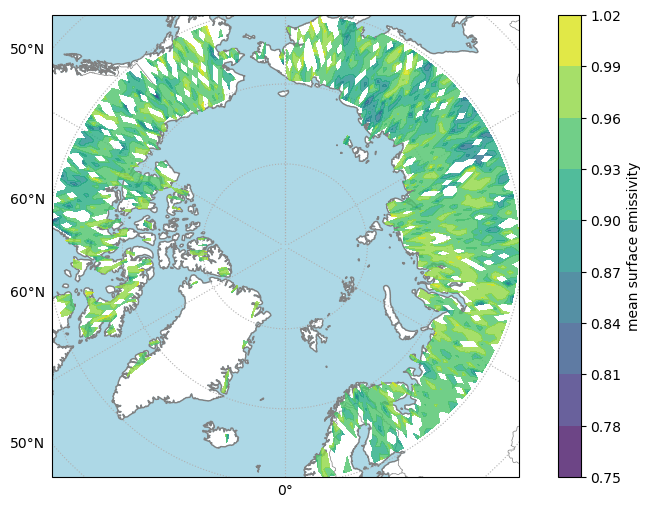

In [61]:
fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={"projection": projection})

make_nice_map(ax)

contour_handle = ax.contourf(
    x, y, values,
    transform=ccrs.PlateCarree(),
    alpha=0.8,
    zorder=2,
)

cb = plt.colorbar(contour_handle)
cb.set_label(label_from_attrs(values))

plt.show()

## Summary

🎉 **Congratulations!** You've successfully created a cloud-native data analysis workflow.

### What You Accomplished
✅ **Built a virtual datacube** from {len(results)} satellite files without downloading  
✅ **Created a ~12MB reference file** representing GB+ of data  
✅ **Analyzed and visualized** satellite data directly from cloud storage  
✅ **Learned transferable skills** for other cloud-hosted datasets  

### Real-World Impact
This approach enables researchers to:
- 🌍 **Analyze large-scale datasets** on modest hardware
- 🤝 **Share analysis-ready datasets** via lightweight reference files  
- ⚡ **Prototype quickly** without waiting for downloads

### Next Steps
- **Expand temporally**: Add date ranges to process months/years of data
- **Try other missions**: Apply to MODIS, GOES, or other NASA datasets
- **Add parallel processing**: Use Dask for distributed computing
- **Share your work**: Export reference files for collaborators
- 
### Resources
📚 [Kerchunk documentation](https://fsspec.github.io/kerchunk/) • [VirtualiZarr tutorials](https://virtualizarr.readthedocs.io/) • [NASA Earthdata Cloud](https://earthdata.nasa.gov/earth-observation-data/cloud-data-access-architecture)